# **Outline**
As we spend between 80-90% of our time indoors, maintaining optimal environmental conditions while minimising energy usage in Heating, Ventilation, and Air Conditioning (HVAC) systems is a huge challenge. Despite substantial investments in regulating indoor environments, energy efficiency remains a major concern.

For instance, when someone sets a thermostat and then leaves the space, the system continues to operate until the room reaches the set temperature, regardless of occupancy. This leads to unnecessary energy consumption.

Motion sensors, though useful, fail to account for stationary occupants, causing inconveniences like lights turning off unexpectedly (a common frustration in student accomodations). To better manage heating, cooling, and ventilation, we propose developing a more sophisticated system that considers multiple factors to accurately determine the number of occupants in a room. This approach aims to enhance both energy efficiency and occupant comfort.


# **Part 1**

###*Using an Arduino and sensors, gather real time data on air quality factors (temperature, humidity, and CO2) in this room, and how they vary with the number of occupants in a room.*

We have provided the code below, but you will need to set up the sensors yourself.

In [ ]:
#include "DHT.h"
#define DHTPIN 2     // Digital pin connected to the DHT sensor
#define DHTTYPE DHT11   // DHT 11

DHT dht(DHTPIN, DHTTYPE); // Initialize DHT sensor

// OLED
#include <SPI.h>
#include <Wire.h>
#include <Adafruit_GFX.h>
#include <Adafruit_SH110X.h>
#define i2c_Address 0x3c
#define SCREEN_WIDTH 128 // OLED display width, in pixels
#define SCREEN_HEIGHT 64 // OLED display height, in pixels
#define OLED_RESET -1   // QT-PY / XIAO
Adafruit_SH1106G display = Adafruit_SH1106G(SCREEN_WIDTH, SCREEN_HEIGHT, &Wire, OLED_RESET);

void setup() {
  Serial.begin(9600); // Set serial baud rate to 9600 bps
  dht.begin();

  delay(250); // Wait for the OLED to power up
  display.begin(i2c_Address, true); // Address 0x3C default
  delay(2000);

  // Clear the buffer.
  display.clearDisplay();
}

void printText(float h, float t, int val){
  display.setCursor(0, 0);
  display.println("Humidity: ");
  display.print(h);
  display.println("%");
  display.println("Temperature: ");
  display.print(t);
  display.println("°C");
  display.println("Gas: ");
  display.print(val);
  display.display();
}

void loop() {
  display.clearDisplay();

  delay(2000); // Wait a few seconds between measurements.

  // DHT11
  float h = dht.readHumidity();
  float t = dht.readTemperature();

  if (isnan(h) || isnan(t)) {
    Serial.println(F("Failed to read from DHT sensor!"));
      return;
  }

  Serial.print(F("Humidity: "));
  Serial.print(h);
  Serial.print(F("%  Temperature: "));
  Serial.print(t);
  Serial.print(F("°C "));

  // Gas sensor
  int val = analogRead(0); // Read Gas value from analog 0

  Serial.print(F(" Gas: "));
  Serial.println(val);

  printText(h, t, val);

  delay(500); // Update display every 500 ms
}

# **Part 2**
###*Using the dataset provided, train a machine learning classification model to predict the occupancy of a room based on environmental conditions.*

## **Classification in Machine Learning**

#### Assigning data points,..
- e.g. temperature, humidity, light and CO2 (independent variables/features) in a room at a given point

#### ..to discrete labels
- e.g. integers denoting the number of occupants in the room (dependent variable/prediction)


## **K-Nearest Neighbours (KNN)**
- A classification algorithm that looks at the 'k' nearest labelled neighbours to a new data point,
- ...then labels the new point with the class label of majority of its neighbours (or the average value of nearest neighbours in case of a tie).
- We usually set k to an odd number to avoid ties.


## **KNN Example with Two Features**
- As our HVAC dataset has 5 feature variables, it will be difficult to illustrate KNN with it (we will need a 5D plot).
- To get an idea of how K-Nearest Neighbours works, it is best to start with a simple two-feature dataset so we can group points on Cartesian graph.
- We will use the implementation of KNN provided by the scikit-learn (sklearn) library.
- We will apply the make_blobs() function from sklearn.datasets to randomly generate clustered data.

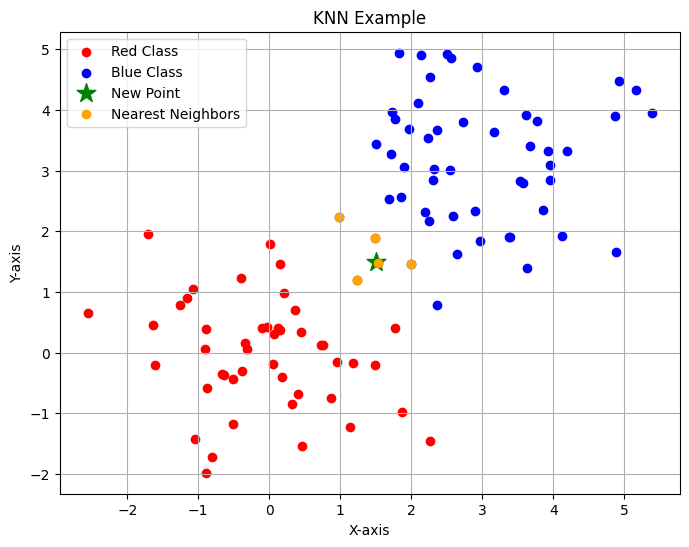

In [2]:
# Import necessary libraries
import numpy as np # For numerical operations.
import matplotlib.pyplot as plt # For plotting data points.
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

# Generate synthetic labeled dataset with 3 classes
# Generating random data points
np.random.seed(0)
X_red = np.random.normal(loc=0.0, scale=1.0, size=(50, 2))
X_blue = np.random.normal(loc=3.0, scale=1.0, size=(50, 2))

# Plotting the data points
plt.figure(figsize=(8, 6))
plt.scatter(X_red[:, 0], X_red[:, 1], color='red', label='Red Class')
plt.scatter(X_blue[:, 0], X_blue[:, 1], color='blue', label='Blue Class')
plt.title('KNN Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Plotting the new data point (star)
new_point = np.array([[1.5, 1.5]])  # coordinates of the new point
plt.scatter(new_point[:, 0], new_point[:, 1], color='green', marker='*', s=200, label='New Point')

# Highlighting the K nearest neighbors
k = 5
all_points = np.vstack([X_red, X_blue])
distances = np.linalg.norm(all_points - new_point, axis=1)
nearest_indices = np.argsort(distances)[:k]
nearest_points = all_points[nearest_indices]
plt.scatter(nearest_points[:, 0], nearest_points[:, 1], color='orange', label='Nearest Neighbors')

plt.legend()
plt.grid(True)

## **KNN with the HVAC Data**
- We have three datsets - one for training the model, and two for testing the trained model's prediction accuracy.
- KNN is a supervised algorithm, meaning it uses labelled data sets, learning to predict target labels with guidance from known outcomes.
- In each of our HVAC datasets, data points (air quality factor combinations/independent variables) are labelled with the true number of observed occupants (dependent variable).

###**1. Importing Libraries and Reading the Data**

In [ ]:
import pandas as pd # data analysis and manipulation library
from sklearn.preprocessing import MinMaxScaler #
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns; sns.set()
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot

# Load the data from text files

# One for training the model...
datatraining = pd.read_csv('datatraining.txt')
# ...,and two for testing its performance
datatest = pd.read_csv('datatest.txt')
datatest2 = pd.read_csv('datatest2.txt')

# Convert date columns to datetime if present and reset index
datatraining['date'] = pd.to_datetime(datatraining['date'])
datatest['date'] = pd.to_datetime(datatest['date'])
datatest2['date'] = pd.to_datetime(datatest2['date'])

datatraining.reset_index(drop=True, inplace=True)
datatest.reset_index(drop=True, inplace=True)
datatest2.reset_index(drop=True, inplace=True)

###**2. What the Datasets Look Like**

Each of our three datasets have the same structure, with features and labels of the same data type. Let's look at the training data:

In [1]:
print(datatraining.info())
datatraining.head()

NameError: name 'datatraining' is not defined

### **3. Air Quality Factors and Occupancy Over Time**

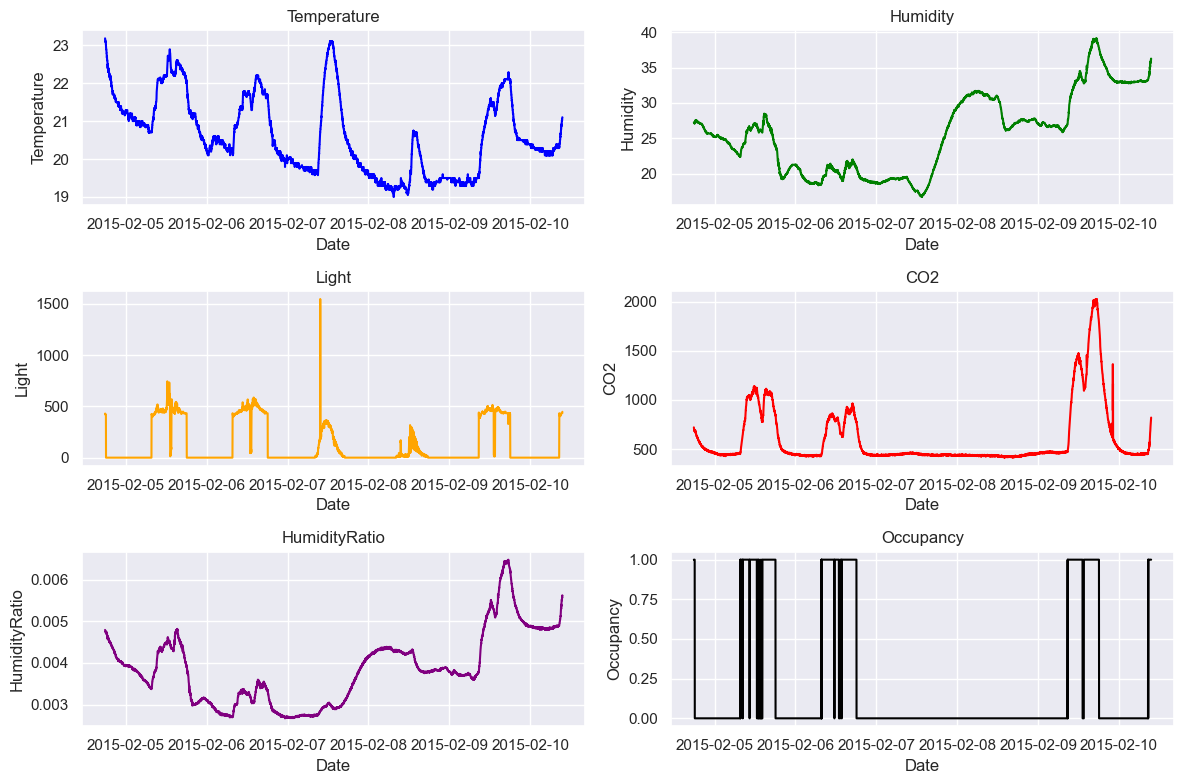

In [ ]:
# Define the feature columns
columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

# Plot the training dataset
# We use separate graphs, rather than a 5D plot, for clarity
plt.figure(figsize=(12, 8))
columns_to_plot = columns + ['Occupancy']
colors = ['blue', 'green', 'orange', 'red', 'purple', 'black']

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(3, 2, i)
    plt.plot(datatraining['date'], datatraining[column], color=colors[i-1])
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

###**4. Normalisation**
Normalisation addresses disparities in the ranges of different features in a dataset by bringing them to a consistent scale, typically between 0 and 1, so that each feature contributes proportionally to the learning process. By preventing features with larger scales from dominating model training, we achieve a better performing model.

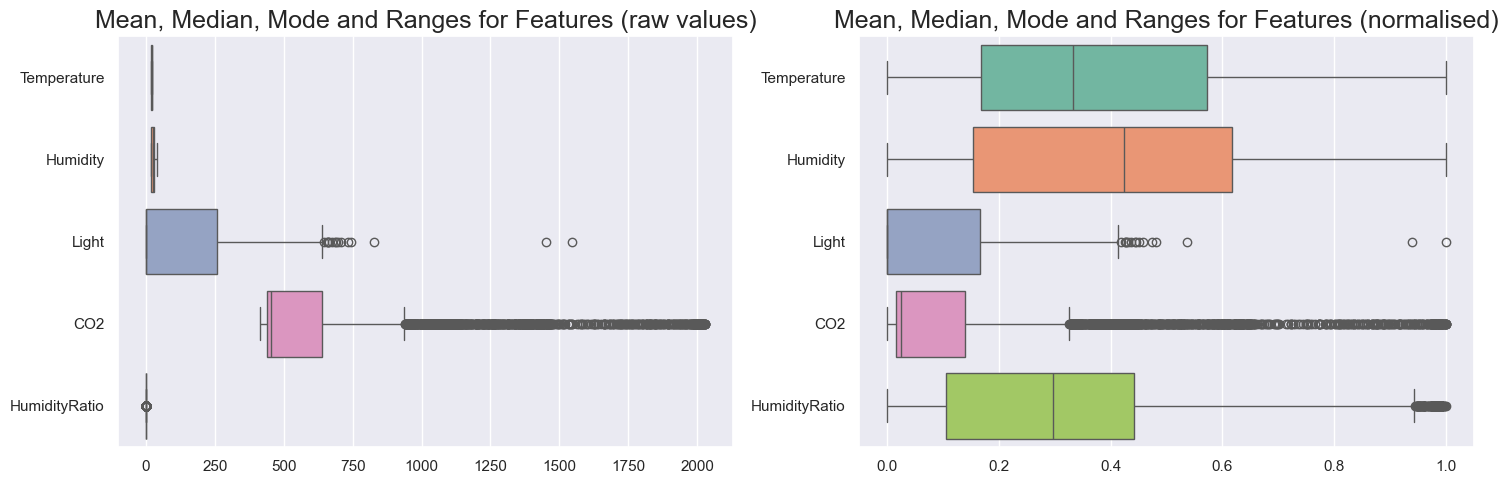

In [ ]:
# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot of features before normalisation
axes[0].set_title('Mean, Median, Mode and Ranges for Features (raw values)', fontdict={'fontsize':18})
sns.boxplot(data=datatraining.drop(['date', 'Occupancy'], axis=1), orient="h", palette="Set2", ax=axes[0])

# Scale the data
scaler = MinMaxScaler()
scaler.fit(np.array(datatraining[columns]))
datatest[columns] = scaler.transform(np.array(datatest[columns]))
datatest2[columns] = scaler.transform(np.array(datatest2[columns]))
datatraining[columns] = scaler.transform(np.array(datatraining[columns]))

# Box plot of features after normalisation
axes[1].set_title('Mean, Median, Mode and Ranges for Features (normalised)', fontdict={'fontsize':18})
sns.boxplot(data=datatraining.drop(['date', 'Occupancy'], axis=1), orient="h", palette="Set2", ax=axes[1])

# Display the plots
plt.tight_layout()
plt.show()


###**5. Colinearity**
**Colinearity refers to correlation between predictor variables (independent variables), and is often observed when we have several predictors.**


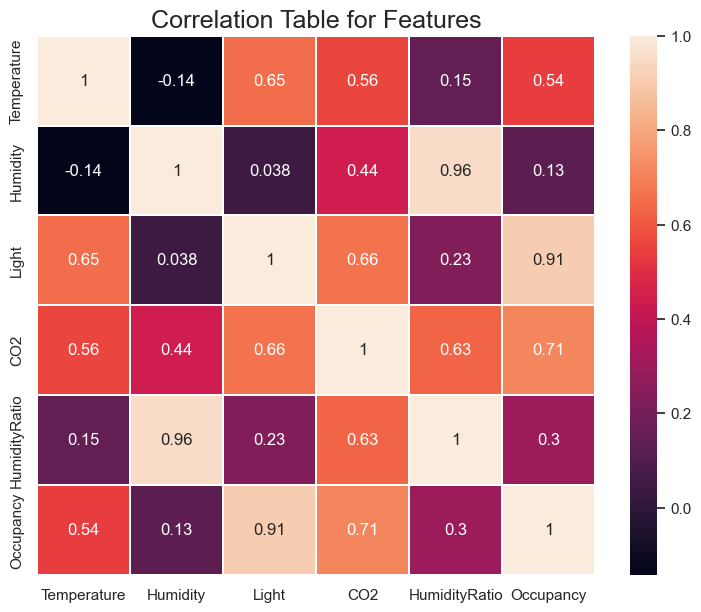

In [ ]:
plt.figure(figsize=(9,7))
plt.title('Correlation Table for Features', fontdict={'fontsize':18})
ax = sns.heatmap(datatraining.corr(), annot=True, linewidths=.2)

###**6. Training and Testing the Classifier with Different Hypermarameters**
Unlike parameters (features), which determine the model itself, hyperparameters specify details of the **learning process**. For example, how many neighbours to consider or how to measure the distamce between points*.

We cannot tell beforehand which combination of hyperparamets will yield the most accurate trained model, so we try a bunch and see.

*M

In [ ]:

# Define features and target for training and testing datasets
X_train = datatraining.drop(columns=['date', 'Occupancy'], axis=1)
y_train = datatraining['Occupancy']
X_validation = datatest.drop(columns=['date', 'Occupancy'], axis=1)
y_validation = datatest['Occupancy']
X_test = datatest2.drop(columns=['date', 'Occupancy'], axis=1)
y_test = datatest2['Occupancy']

# parameter-tuning for knn
n_neighbors_list = [7,15,45,135]
metric_list = ['euclidean', 'manhattan']
accuracies = {}
for n in n_neighbors_list:
    for metric in metric_list:
        knn_model = KNeighborsClassifier(n_neighbors=n, metric=metric)
        knn_model.fit(X_train, y_train)
        accuracy = knn_model.score(X_validation, y_validation)
        accuracies["k="+str(n)+"/"+metric] = accuracy

plotdata = pd.DataFrame()
plotdata['Parameters'] = accuracies.keys()
plotdata['Accuracy'] = accuracies.values()
fig = px.line(plotdata, x="Parameters", y="Accuracy")
fig.update_layout(title={'text': "Accuracies for Different Hyper-Parameters",
                                                'x':0.5,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

[Edited Notebook from OMER TURKSOY](https://www.kaggle.com/code/turksoyomer/hvac-occupancy-detection-with-ml-and-dl-methods#3.-Classification-with-Machine-Learning-Methods)